In [1]:
from matplotlib import pyplot as plt
from openbci_stream.utils import HDF5Writer, HDF5Reader
import numpy as np
from datetime import datetime
import seaborn as sns
import os

In [44]:
def near_to(l1, l2):
    return l1, [l2[np.abs(l2-v).argmin()] for v in l1]

def remove_outlayers(l):
    l = l[l > (l.mean() - (2 * l.std()))]
    l = l[l < (l.mean() + (2 * l.std()))]
    return l

In [120]:
files = os.listdir('/home/yeison/.bciframework/records')
files.sort()


MARKERS = {
    'MARKER': 'C1',
#     'HIGH.post': 'C2',
#     'LOW': 'C3',
#     'LOW.post': 'C4',
        }

print(files[-1])
with HDF5Reader(os.path.join('/home/yeison/.bciframework/records', files[-1])) as reader:
    print(reader.header)

    analog = reader.aux[0]
    time = reader.timestamp_relative
    timestamp = reader.timestamp

#     threshold = np.mean(analog)#+(np.std(analog)*0.5)

    threshold =  analog.min() + (analog.max() - analog.min())/2

    analog_d =  analog.copy()
    analog_d[analog_d<threshold] = 0
    analog_d[analog_d>=threshold] = 1

    analog =  analog-analog.min()
    analog = analog/analog.max()

    rise_up_relative = time[np.diff(analog_d, append=0)>0.5]
    rise_up_absolute = timestamp[np.diff(analog_d, append=0)>0.5]

    markers_relative = np.array(sorted(np.concatenate([reader.markers_relative[key] for key in MARKERS.keys()])))
    markers_absolute = np.array(sorted(np.concatenate([reader.markers[key] for key in MARKERS.keys()])))

record-01_26_21-17_00_16.h5
{'sample_rate': 1000, 'streaming_sample_rate': 250, 'datetime': 1611698416.420913, 'montage': 'standard_1020', 'channels': {1: 'Fp1', 2: 'Fp2', 3: 'T3', 4: 'C3', 5: 'C4', 6: 'T4', 7: 'O1', 8: 'O2'}, 'start-offset': -7.477045059204102, 'shape': [8, 45250], 'end-offset': -10.637998580932617}


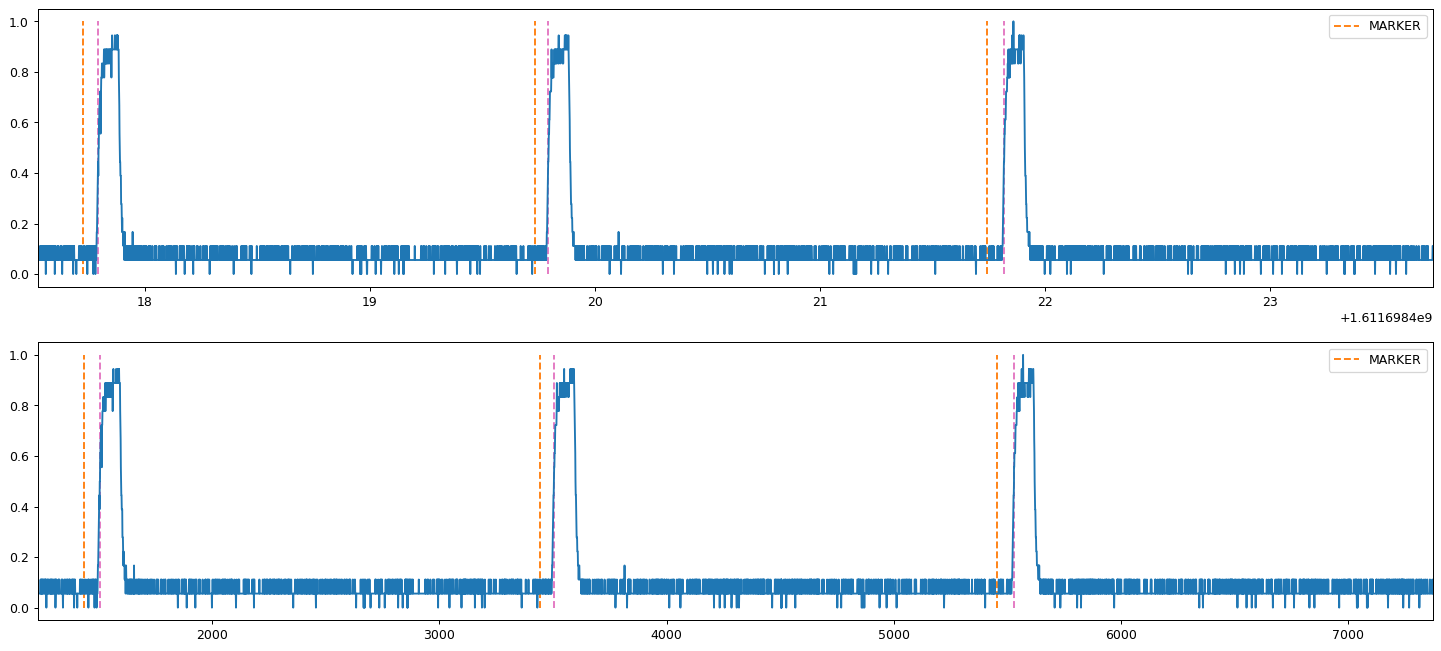

In [121]:
plt.figure(figsize=(20,9), dpi=90)

plt.subplot(211)

plt.plot(timestamp, analog, '-')
# plt.plot(timestamp, analog_d, '-o')
plt.vlines(rise_up_absolute, 0, 1, color=f'C6', linestyle='--',)


for c, key in enumerate(reader.markers.keys()):
    if key in MARKERS:
        plt.vlines(reader.markers[key], 0, 1, color=MARKERS[key], linestyle='--', label=key)
    
    
f = reader.markers['MARKER'][0]
plt.xlim(f-0.2, f+0.4*15)
# plt.xlim(timestamp[0]+1, timestamp[0]+5)
plt.legend()


plt.subplot(212)


plt.plot(time, analog, '-')
# plt.plot(time, analog_d, '-o')
plt.vlines(rise_up_relative, 0, 1, color=f'C6', linestyle='--',)
# plt.vlines(rise_up_relative-100, 0, 1.5, color=f'C7', linestyle='--',)

for c, key in enumerate(reader.markers_relative.keys()):
    if key in MARKERS:
        plt.vlines(np.array(reader.markers_relative[key]), 0, 1, color=MARKERS[key], linestyle='--', label=key)
plt.legend()
f = reader.markers_relative['MARKER'][0]
plt.xlim(f-203, f+396*15)

plt.savefig("latency1.png")

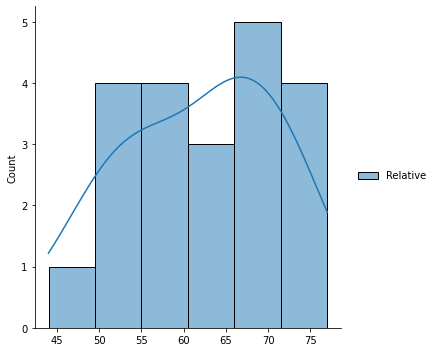

In [122]:
latency_relative = np.array(np.subtract(*near_to(markers_relative, rise_up_relative)))
latency_absolute = np.array([(datetime.fromtimestamp(rise)-datetime.fromtimestamp(mk)).total_seconds()*1000 for rise, mk in zip(*near_to(markers_absolute, rise_up_absolute))])

data = {
#     'Abolute': -remove_outlayers(latency_absolute),
       'Relative': -remove_outlayers(latency_relative),
       }

sns.displot(data, kde=True)
plt.savefig("latency2.png")

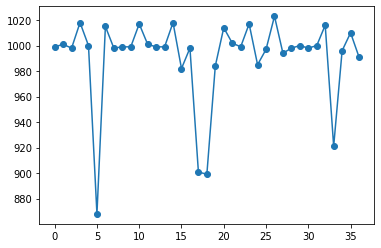

In [108]:
plt.plot(remove_outlayers(np.diff(rise_up_relative)), '-o')